In [1]:
import os
import pandas as pd
import PyPDF2
import nltk
import re
import joblib
import shutil
import tkinter as tk
from tkinter import filedialog, messagebox
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove numbers/symbols
    text = text.lower().split()
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

# Load dataset
df = pd.read_csv('Resume.csv')
df['cleaned_text'] = df['Resume_str'].apply(preprocess_text)


# Function to extract text from PDFs
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            text = " ".join([page.extract_text() for page in reader.pages if page.extract_text()])
    except Exception as e:
        print(f"Error reading {pdf_path}: {str(e)}")
    return preprocess_text(text)

# Load PDFs from directory
pdf_folder = "data"  # Change this to your actual folder path
pdf_texts = []
pdf_categories = []

for category in os.listdir(pdf_folder):  # Assuming folders are named by category
    category_path = os.path.join(pdf_folder, category)
    if os.path.isdir(category_path):
        for pdf_file in os.listdir(category_path):
            pdf_path = os.path.join(category_path, pdf_file)
            text = extract_text_from_pdf(pdf_path)
            if text:
                pdf_texts.append(text)
                pdf_categories.append(category)

# Convert to DataFrame and merge with CSV data
pdf_df = pd.DataFrame({"cleaned_text": pdf_texts, "Category": pdf_categories})

df = pd.concat([df[['cleaned_text', 'Category']], pdf_df], ignore_index=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Display the first few rows of the DataFrame to see how the data looks
print(df.head())




                                        cleaned_text Category
0  hr administrator marketing associate hr admini...       HR
1  hr specialist us hr operations summary versati...       HR
2  hr director summary years experience recruitin...       HR
3  hr specialist summary dedicated driven dynamic...       HR
4  hr manager skill highlights hr skills hr depar...       HR


In [4]:
# Show some basic info about the dataset
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4955 entries, 0 to 4954
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  4955 non-null   object
 1   Category      4955 non-null   object
dtypes: object(2)
memory usage: 77.6+ KB
None


In [6]:

# Check the distribution of categories
print(df['Category'].value_counts())

# Show the first few cleaned text entries
print(df['cleaned_text'].head())

Category
BUSINESS-DEVELOPMENT      239
INFORMATION-TECHNOLOGY    238
ADVOCATE                  236
CHEF                      236
ENGINEERING               236
ACCOUNTANT                236
FINANCE                   235
FITNESS                   234
AVIATION                  234
SALES                     231
BANKING                   230
CONSULTANT                229
HEALTHCARE                227
CONSTRUCTION              224
PUBLIC-RELATIONS          220
HR                        218
DESIGNER                  214
ARTS                      206
TEACHER                   204
APPAREL                   194
DIGITAL-MEDIA             192
AGRICULTURE               126
AUTOMOBILE                 72
BPO                        44
Name: count, dtype: int64
0    hr administrator marketing associate hr admini...
1    hr specialist us hr operations summary versati...
2    hr director summary years experience recruitin...
3    hr specialist summary dedicated driven dynamic...
4    hr manager skill hig

In [7]:
# View some samples of cleaned text
for i in range(5):
    print(f"Sample {i+1} cleaned text: {df['cleaned_text'].iloc[i]}")


Sample 1 cleaned text: hr administrator marketing associate hr administrator summary dedicated customer service manager years experience hospitality customer service management respected builder leader customer focused teams strives instill shared enthusiastic commitment customer service highlights focused customer satisfaction team management marketing savvy conflict resolution techniques training development skilled multi tasker client relations specialist accomplishments missouri dot supervisor training certification certified ihg customer loyalty marketing segment hilton worldwide general manager training certification accomplished trainer cross server hospitality systems hilton onq micros opera pms fidelio opera reservation system ors holidex completed courses seminars customer service sales strategies inventory control loss prevention safety time management leadership performance assessment experience hr administrator marketing associate hr administrator dec current company name 

In [8]:
# Show a random sample of rows
print(df.sample(5))


                                           cleaned_text  \
3571  physical therapist technician education glenco...   
261   information technology specialist infosec summ...   
1659  associate merchant summary resourceful buyer y...   
1354  services engineer summary seeking challenging ...   
4618  information technology intern professional pro...   

                    Category  
3571            CONSTRUCTION  
261   INFORMATION-TECHNOLOGY  
1659                 APPAREL  
1354              AUTOMOBILE  
4618  INFORMATION-TECHNOLOGY  


C:\Users\Enter\AppData\Local\Temp\ipykernel_11532\3228172842.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Category'], order=df['Category'].value_counts().index, palette='coolwarm')


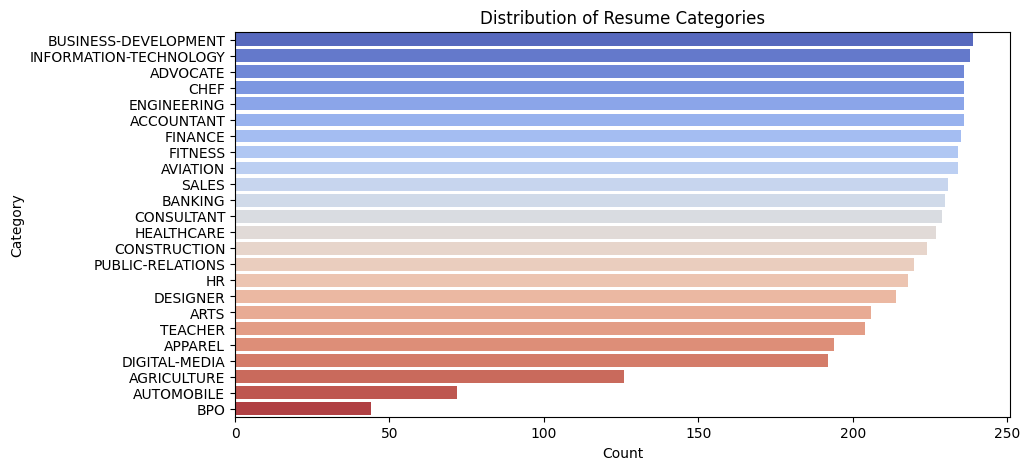

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data Visualization
def plot_category_distribution():
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df['Category'], order=df['Category'].value_counts().index, palette='coolwarm')
    plt.title("Distribution of Resume Categories")
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()




# Display visualizations
plot_category_distribution()

C:\Users\Enter\AppData\Local\Temp\ipykernel_11532\3934325871.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words_df, palette='Blues_d')


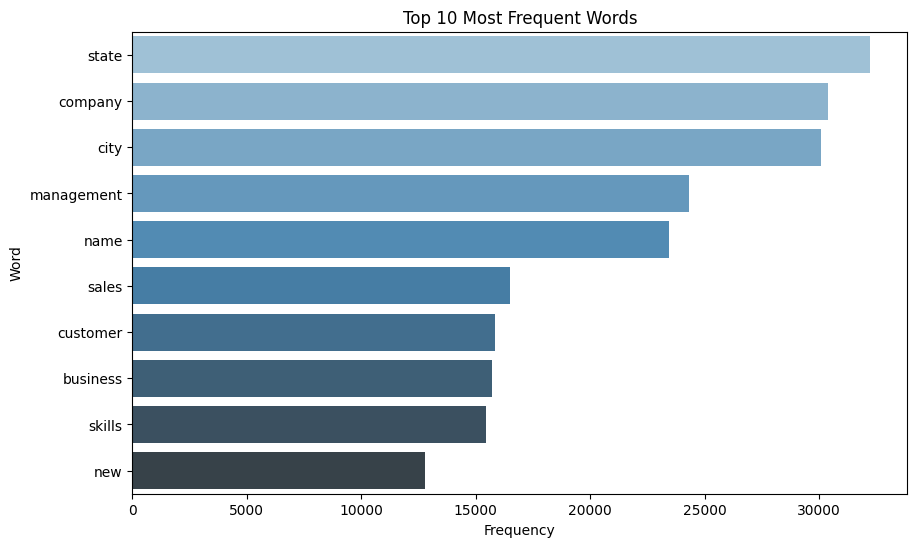

In [10]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the cleaned text and get the frequency of each word
all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

# Get the top 10 most common words
top_words = word_freq.most_common(10)

# Plot the top 10 words
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_words_df, palette='Blues_d')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


In [21]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


# Encode target labels
label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

# Convert text into numerical format
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Unigrams + Bigrams
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['Category_encoded']

# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train multiple models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=150, random_state=42, class_weight="balanced"),
    'LogisticRegression': LogisticRegression(max_iter=700),
    'SVM': SVC(kernel='linear', probability=True),
    'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

best_model, best_accuracy = None, 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔹 {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))
    
    if acc > best_accuracy:
        best_accuracy, best_model = acc, model

# Save the best model and vectorizer
joblib.dump(best_model, 'best_resume_classifier1.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer1.pkl')
joblib.dump(label_encoder, 'label_encoder1.pkl')

print("\n✅ Model training complete. Best model saved!")



🔹 RandomForest Accuracy: 0.9782
                        precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00        55
              ADVOCATE       0.93      0.93      0.93        58
           AGRICULTURE       0.96      1.00      0.98        51
               APPAREL       1.00      0.96      0.98        48
                  ARTS       1.00      0.83      0.91        36
            AUTOMOBILE       1.00      1.00      1.00        44
              AVIATION       1.00      1.00      1.00        45
               BANKING       1.00      0.91      0.95        43
                   BPO       1.00      1.00      1.00        46
  BUSINESS-DEVELOPMENT       0.91      1.00      0.95        39
                  CHEF       1.00      1.00      1.00        38
          CONSTRUCTION       0.92      1.00      0.96        44
            CONSULTANT       1.00      0.94      0.97        49
              DESIGNER       1.00      1.00      1.00        49
      

In [27]:
import os
import shutil
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter import ttk
import joblib
import numpy as np
import fitz  # PyMuPDF for PDF text extraction
from pathlib import Path

# Load trained model, vectorizer, and label encoder
model = joblib.load('best_resume_classifier1.pkl')
vectorizer = joblib.load('tfidf_vectorizer1.pkl')
label_encoder = joblib.load('label_encoder1.pkl')

# Create the Categorized_Resumes folder if it doesn't exist
categorized_resumes_path = "Categorized_Resumes"
os.makedirs(categorized_resumes_path, exist_ok=True)

# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    try:
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text("text")  # Extract plain text from each page
        doc.close()
        return text.strip()
    except Exception as e:
        print(f"❌ Error extracting text from {pdf_path}: {e}")
        return ""

# Function to classify uploaded resume
def classify_resume():
    file_path = filedialog.askopenfilename(filetypes=[("PDF files", "*.pdf")])
    if not file_path:
        return

    # Extract text from the PDF file
    text = extract_text_from_pdf(file_path)
    if not text:
        messagebox.showerror("Error", "Failed to extract text from PDF. Try another file.")
        return

    print("\n📝 Extracted Text Preview:\n", text[:1000])  # Print first 1000 characters for debugging

    # Transform text using TF-IDF
    vectorized_text = vectorizer.transform([text]).toarray()

    # Predict category & confidence
    probabilities = model.predict_proba(vectorized_text)[0]
    encoded_category = np.argmax(probabilities)
    confidence_score = max(probabilities)

    # Decode category
    category = label_encoder.inverse_transform([encoded_category])[0]

    print(f"🔹 Predicted: {category} | Confidence: {confidence_score:.2f}\n")

    # Move to category folder
    category_folder = os.path.join(categorized_resumes_path, category)
    os.makedirs(category_folder, exist_ok=True)
    shutil.move(file_path, os.path.join(category_folder, os.path.basename(file_path)))

    messagebox.showinfo("Success", f"Resume classified as {category} (Confidence: {confidence_score:.2f})")
    update_category_list()

# Function to update the list of available categories in the GUI
def update_category_list():
    listbox_categories.delete(0, tk.END)

    # Check the Categorized_Resumes folder for subfolders (categories)
    if os.path.exists(categorized_resumes_path):
        categories = [f.name for f in Path(categorized_resumes_path).iterdir() if f.is_dir()]
    else:
        categories = []
    
    # Add categories to Listbox
    for category in categories:
        listbox_categories.insert(tk.END, category)

# Function to open the selected folder
def open_category_folder():
    selected_category = listbox_categories.get(tk.ACTIVE)
    if selected_category:
        folder_path = os.path.join(categorized_resumes_path, selected_category)
        if os.path.exists(folder_path):
            os.startfile(folder_path) if os.name == 'nt' else os.system(f'xdg-open "{folder_path}"')
        else:
            messagebox.showerror("Error", "The folder could not be opened!")
    else:
        messagebox.showwarning("No Category Selected", "Please select a category to open.")

# Create the main GUI window
root = tk.Tk()
root.title("Resume Classifier")
root.geometry("500x500")
root.config(bg="#f4f4f9")  # Light background color

# Create a frame for buttons
frame_buttons = ttk.Frame(root, padding="20")
frame_buttons.pack(pady=20, fill="x")

# Upload Resume Button
btn_upload = ttk.Button(frame_buttons, text="Upload Resume", command=classify_resume, width=20)
btn_upload.grid(row=0, column=0, padx=10, pady=10)

# View Categorized Resumes Button
btn_view = ttk.Button(frame_buttons, text="View Categorized Resumes", command=open_category_folder, width=20)
btn_view.grid(row=0, column=1, padx=10, pady=10)

# Create a frame for Listbox and scrollbar
frame_listbox = ttk.Frame(root, padding="10")
frame_listbox.pack(fill="both", expand=True)

# Listbox to display categories
listbox_categories = tk.Listbox(frame_listbox, height=10, width=40, font=("Arial", 12), selectmode=tk.SINGLE)
listbox_categories.pack(side="left", fill="both", expand=True)

# Scrollbar for Listbox
scrollbar = ttk.Scrollbar(frame_listbox, orient="vertical", command=listbox_categories.yview)
scrollbar.pack(side="right", fill="y")
listbox_categories.config(yscrollcommand=scrollbar.set)

# Update the category list after initializing the GUI
update_category_list()

# Run the main loop
root.mainloop()



📝 Extracted Text Preview:
 ASSISTANT DIRECTOR OF POLAR EXPEDITIONS
Summary
To acquire an executive assistant position with a dynamic company. My detailed project management, writing, creative and communication
experience will allow me to take a leadership role in managing multiple responsibilities.
Highlights
Strong digital/film photography, photo editing and print design skills *Great presentation skills creating visually appealing and concise
presentations, proposals and brochures *PC/Mac literate: Word, Excel, Outlook, PhotoShop, InDesign, PowerPoint, MapPoint, Leo Software
Experience
04/2011 to 12/2011
Assistant Director of Polar Expeditions Company Name ï¼​ City , State
Expedition sales and procurement: Sold polar adventure expeditions to global clientele and maintained client and vendor relationships.
Communicated to clients the details of expeditions (cost, payments, what to expect, requirements & forms).
Developed and contributed to the success of the largest South Pole season